In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModel import TrainSingleModel
from Classes.DataProcessing.RamLoader import RamLoader
from Classes.DataProcessing.ts_RamGenerator import modified_data_generator
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)



model_type = "LSTM_baseline"
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "standard"
use_noise_augmentor = False
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = False)

x_train, y_train, x_val, y_val, x_test, y_test, noiseAug = ramLoader.load_to_ram()



1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6
2 3
Balancing due to disguised labels.
This functions barely works, and is a piece of shit that should not be trusted. Only works because noise has id: 0
{'noise': 84799, 'earthquake': 84799, 'explosion': 82246}
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded noise non-noise dataset.
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (10631, 0.2526)  |  explosion: (10106, 0.2402)  |  noise: (21343, 0.5072)  
Val ds:
earthquake: (242, 0.0371)  |  explosion: (3125, 0

In [2]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = False
start_from_scratch = False
use_reduced_lr = False
log_data = True

def clear_tensorboard_dir():
        import os
        import shutil
        path = f"{base_dir}/Tensorboard_dir/fit"
        files = os.listdir(path)
        print(files)
        for f in files:
            shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()


modelTrain = TrainSingleModel(x_train, y_train, x_val, y_val, x_test, y_test, noiseAug, helper,
                              loadData, model_type, num_channels, use_tensorboard, use_liveplots,
                              use_custom_callback, use_early_stopping, use_reduced_lr, ramLoader,
                              log_data = log_data, results_df = None, results_file_name = None, index = None, 
                              start_from_scratch = start_from_scratch)
params = {
        "batch_size" : 128,
        "epochs" : 50,
        "learning_rate" : 0.01,
        "optimizer" : "sgd",
        "units" : 1,
        "output_layer_activation" : "sigmoid"
    }

model, _ = modelTrain.run(16, 15, evaluate_train = True, evaluate_val = True, evaluate_test = True, meier_mode = False, **params)

['20210420-214858']
Trying to create result file
Made result file:  results_LSTM_baseline_noiseNotNoise_timeAug_standard_unbalanced_valtest_subsample-0.25_numChannels-3_f1.csv
[   {'model_type': 'LSTM_baseline'},
    {   'batch_size': 128,
        'epochs': 50,
        'learning_rate': 0.01,
        'optimizer': 'sgd',
        'output_layer_activation': 'sigmoid',
        'units': 1}]
Saving file. 2 rows.
results_LSTM_baseline_noiseNotNoise_timeAug_standard_unbalanced_valtest_subsample-0.25_numChannels-3_f1.csv saved to path:   /media/tord/T7/Thesis_ssd/MasterThesis3/GridSearchResults/2_classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000, 3)]         0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 1)                 24        
_____________________________________________________

- val_f1: 0.0
Epoch 25/50
328/328 [==============================] - 38s 117ms/step - loss: 0.6930 - binary_accuracy: 0.5077 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6937 - val_binary_accuracy: 0.4844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
- val_f1: 0.0
Epoch 26/50
328/328 [==============================] - 38s 116ms/step - loss: 0.6930 - binary_accuracy: 0.5077 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6936 - val_binary_accuracy: 0.4844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
- val_f1: 0.0
Epoch 27/50
328/328 [==============================] - 38s 115ms/step - loss: 0.6930 - binary_accuracy: 0.5085 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6936 - val_binary_accuracy: 0.4844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
- val_f1: 0.0
Epoch 28/50
328/328 [==============================] - 38s 116ms/step - loss: 0.6930 - binary_accuracy: 0.5085 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.

/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


328/328 [==============================] - 18s 56ms/step - loss: 0.6930 - binary_accuracy: 0.5070 - precision: 0.0000e+00 - recall: 0.0000e+00
21285 0 20699 0
<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[21285,     0],
       [20699,     0]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.51      1.00      0.67     21285
   not_noise       0.00      0.00      0.00     20699

    accuracy                           0.51     41984
   macro avg       0.25      0.50      0.34     41984
weighted avg       0.26      0.51      0.34     41984

Saving file. 2 rows.
results_LSTM_baseline_noiseNotNoise_timeAug_standard_unbalanced_valtest_subsample-0.25_numChannels-3_f1.csv saved to path:   /media/tord/T7/Thesis_ssd/MasterThesis3/GridSearchResults/2_classes
batch_size                                         128
epochs                                              50
learning_rate                                     0.01
optimizer                   

3100 0 3300 0


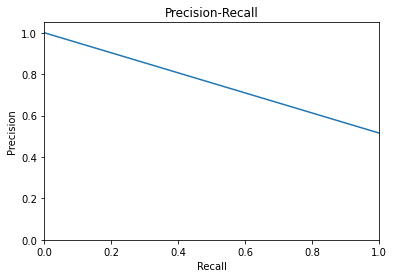

(2, 2)


/media/tord/T7/Thesis_ssd/MasterThesis3/Classes/DataProcessing/HelperFunctions.py:161: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/media/tord/T7/Thesis_ssd/MasterThesis3/Classes/DataProcessing/HelperFunctions.py:162: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


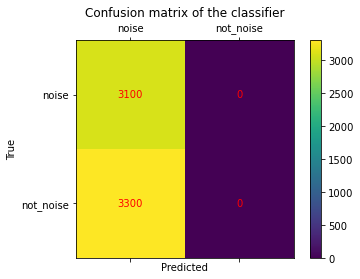

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3100,    0],
       [3300,    0]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.48      1.00      0.65      3100
   not_noise       0.00      0.00      0.00      3300

    accuracy                           0.48      6400
   macro avg       0.24      0.50      0.33      6400
weighted avg       0.23      0.48      0.32      6400



In [3]:
conf, report, precision, recall, fscore, accuracy = helper.evaluate_generator(model, x_val, y_val, params["batch_size"],
                                                                             loadData.label_dict, num_channels, noiseAug,
                                                                             scaler_name, plot_conf_matrix = True, plot_p_r_curve = True)